In [2]:
!pip install matplotlib numpy pandas torch scikit-learn transformers


   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.7 MB 1.2 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/9.7 MB 1.3 MB/s eta 0:00:07
   ----- ---------------------------------- 1.3/9.7 MB 1.3 MB/s eta 0:00:07
   -------- ------------------------------- 2.1/9.7 MB 1.8 MB/s eta 0:00:05
   ----------- ---------------------------- 2.9/9.7 MB 2.1 MB/s eta 0:00:04
   ---------------- ----------------------- 3.9/9.7 MB 2.5 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.7 MB 2.8 MB/s eta 0:00:02
   -------------------------- ------------- 6.3/9.7 MB 3.2 MB/s eta 0:00:02
   ------------------------------- -------- 7.6/9.7 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.7 MB 3.9 MB/s eta 0:00:01
   ------------------------------

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    logging, 
    pipeline,
)

DATA_DIR = "lang.csv"
MODEL_NAME = "bert-base-multilingual-uncased"
RANDOM_STATE = 12345
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 1
LEARNING_RATE = 5e-5

torch.backends.cudnn.deterministic = True
torch.manual_seed(RANDOM_STATE)
logging.set_verbosity_error()

In [4]:
# Displaying the device used for fune-tuning BERT
print(f"Device used: {DEVICE}")

Device used: cpu


# Loading data

In [6]:
# Loading the data
lang_data = pd.read_csv(DATA_DIR )

# Displaying random 30 rows
lang_data.sample(n=30, random_state=RANDOM_STATE)

,Text,Language
1346,oh dear one night when she was sleeping her mo...,English
2184,சந்திப்பு அல்லது தேதி என்று சொல்வது மிகவும் பி...,Tamil
4718,wat dacht je van een ijsje?,Dutch
1041,i'm deluged with assignments smart word number...,English
6772,"han er så klar og suave, især foran damerne el...",Danish
6983,Jeg har ikke en mening om sagen.,Danish
2374,"என்னைப் பொருத்தவரை, இது நகரத்தின் சிறந்த உணவகம்.",Tamil
4856,Existe cierta polémica entre los fundadores de...,Spanish
4209,Veuillez accepter mes excuses.,French
7140,Wales cedette tutti i diritti alla fondazione ...,Italian


In [7]:
# Displaying a concise summary of the data
lang_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


# Data exploration

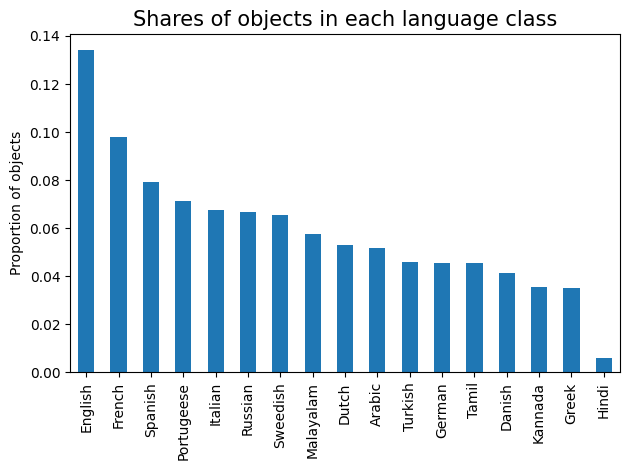

In [8]:
# Plotting the structure of the target variable
lang_counts = lang_data["Language"].value_counts(normalize=True)
lang_counts.plot(kind="bar")
plt.title("Shares of objects in each language class", fontsize=15)
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

# Encoding labels

In [9]:
# Retrieving the text data
texts_data = lang_data["Text"].values.astype("U")

# Retrieving the labels data
labels_data = lang_data["Language"].values

In [10]:
# Instantiating the LabelEncoder object
label_encoder = LabelEncoder()

# Encoding the labels
labels_data_encoded = label_encoder.fit_transform(labels_data)
class_names = label_encoder.classes_

# Displaying the encoding results
for idx, class_name in enumerate(class_names):
    print(f"{idx:<2} => {class_name}")

0  => Arabic
1  => Danish
2  => Dutch
3  => English
4  => French
5  => German
6  => Greek
7  => Hindi
8  => Italian
9  => Kannada
10 => Malayalam
11 => Portugeese
12 => Russian
13 => Spanish
14 => Sweedish
15 => Tamil
16 => Turkish


# Splitting data

In [11]:
# Separating data into training set and validation/test sets
(
training_texts, 
validation_testing_texts, 
training_labels, 
validation_testing_labels
) = train_test_split(
    texts_data,
    labels_data_encoded,
    train_size=0.8,
    random_state=RANDOM_STATE,
    stratify=labels_data_encoded,
)

# Separating validation and test sets
(
validation_texts, 
testing_texts, 
validation_labels, 
testing_labels
) = train_test_split(
    validation_testing_texts,
    validation_testing_labels,
    train_size=0.5,
    random_state=RANDOM_STATE,
    stratify=validation_testing_labels,
)

In [12]:
# Verifying the correctness of dimensions
assert (
    training_texts.shape[0] + validation_texts.shape[0] + testing_texts.shape[0] \
    == texts_data.shape[0]
)

# Displaying the number of objects in each set
training_texts.shape[0], validation_texts.shape[0], testing_texts.shape[0]

(8269, 1034, 1034)

# Data vizualization

In [13]:
def plot_target_structure(labels, fig_title="Title_1"):
    """Plotting the shares of Dataset labels."""
    # Computing the unique labels
    unique_labels = np.unique(labels)
    # Computing the number of objects within each class
    labels_count = np.bincount(labels)
    
    # Computing the shares of objects in each class
    n_obj = labels.shape[0]
    
    labels_info_share = pd.Series(
        labels_count, index=label_encoder.classes_
    ) / n_obj
    
    # Plotting a figure
    labels_info_share.plot(kind="bar")
    plt.xticks(rotation=0)
    plt.title(fig_title, fontsize=15)
    plt.xlabel("Class name")
    plt.ylabel("Proportion of objects")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

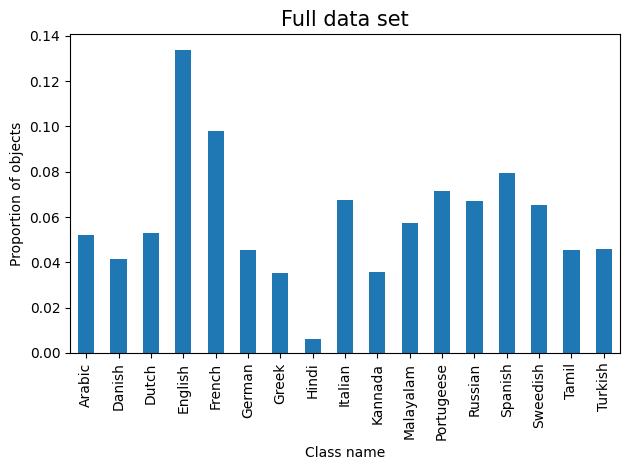

In [14]:
plot_target_structure(
    labels=labels_data_encoded, fig_title="Full data set"
)

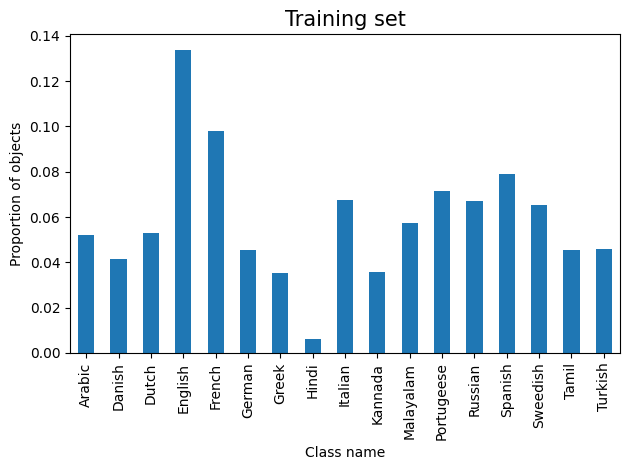

In [15]:
plot_target_structure(
    labels=training_labels, fig_title="Training set"
)

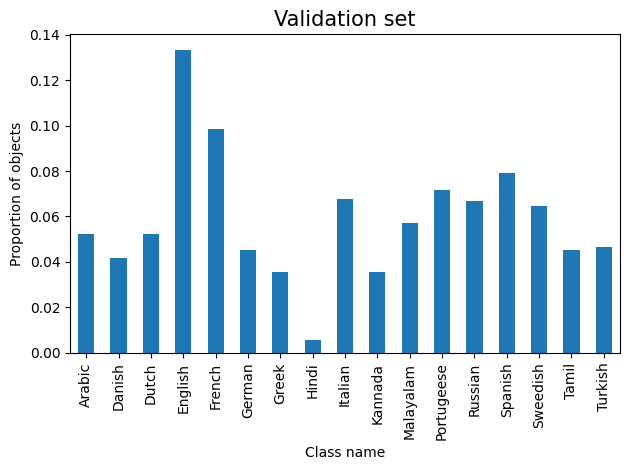

In [16]:
plot_target_structure(
    labels=validation_labels, fig_title="Validation set"
)

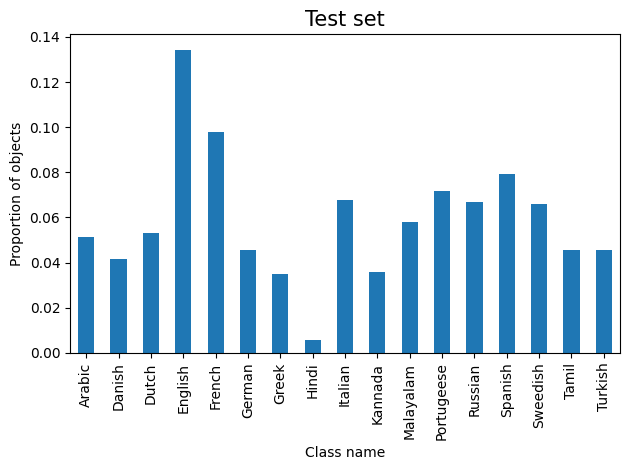

In [17]:
plot_target_structure(
    labels=testing_labels, fig_title="Test set"
)

# Tokenization

In [18]:
# Instantiating a BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\vivek\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vivek\.cache\huggingface\hub\models--bert-base-multilingual-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [19]:
# Tokenizing the training examples
training_encodings = bert_tokenizer(
    list(training_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True, 
    padding="max_length",
)

# Tokenizing the validation examples
validation_encodings = bert_tokenizer(
    list(validation_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True, 
    padding="max_length",
)

# Tokenizing the testing examples
testing_encodings = bert_tokenizer(
    list(testing_texts),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding="max_length",
)

In [20]:
def display_encodings_info(
    tokenizer, 
    encodings, 
    texts, 
    labels,
    text_idx
):
    """Shows the original, encoded and decoded texts."""
    # Displaying the original text
    text = texts[text_idx]
    print(f"Input text:\n{text}\n")
    
    # Displaying the language of the text
    lang_label = labels[text_idx]
    lang = class_names[lang_label]
    print(f"Language: {lang}\n")
    
    # Displaying the encoded text
    text_encoded = encodings["input_ids"][text_idx]
    print(f"Tokenized input text (encoded):\n{text_encoded}\n")
    
    # Displaying the decoded text
    text_decoded = tokenizer.convert_ids_to_tokens(text_encoded)
    print(f"Tokenized input text (decoded):\n{text_decoded}")

In [21]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=training_encodings, 
    texts=training_texts, 
    labels=training_labels,
    text_idx=990,
)

Input text:
est une façon très française de dire réunion ou date par exemple j'ai rendez-vous avec mes amis pendant le déjeuner le samedi ou je prévois de rendez-vous avec mes amis au centre commercial pour les films rendez-vous peut être utilisé à la fois comme nom ou comme verbe par exemple.

Language: French

Tokenized input text (encoded):
[101, 10182, 10249, 28495, 10860, 13903, 10102, 18759, 22600, 10391, 13114, 10263, 15129, 152, 112, 11279, 74427, 118, 22812, 10516, 11019, 32378, 14055, 10130, 10102, 10378, 18712, 10131, 10130, 11714, 10777, 10391, 10149, 12021, 88710, 10102, 74427, 118, 22812, 10516, 11019, 32378, 10257, 11534, 16229, 10343, 10152, 13076, 74427, 118, 22812, 12835, 11787, 18814, 143, 10106, 13488, 11043, 11542, 10391, 11043, 49896, 10111, 10263, 15129, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input te

In [22]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=validation_encodings, 
    texts=validation_texts, 
    labels=validation_labels,
    text_idx=1033,
)

Input text:
Essa foi a primeira enciclopédia interativa (e também foi o primeiro grande documento multimídia conectado através de links internos), sendo a maioria dos artigos acessíveis através de um mapa interativo do Reino Unido.

Language: Portugeese

Tokenized input text (encoded):
[101, 18416, 10464, 143, 13664, 36286, 49487, 16689, 113, 147, 12014, 10464, 157, 13552, 11031, 34132, 17682, 10555, 14302, 64100, 92300, 20712, 10102, 21313, 93117, 114, 117, 14297, 143, 24112, 10426, 72480, 29552, 32297, 29530, 20712, 10102, 10316, 20777, 49487, 17391, 10154, 14855, 19957, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input text (decoded):
['[CLS]', 'essa', 'foi', 'a', 'primeira', 'enciclopedia', 'intera', '##tiva', '(', 'e', 'tambem', 'foi', 'o', 'primeiro', 'grande',

In [23]:
display_encodings_info(
    tokenizer=bert_tokenizer,
    encodings=testing_encodings, 
    texts=testing_texts, 
    labels=testing_labels,
    text_idx=1010,
)

Input text:
narcisa mi aiuteresti a piantare questi semi cosa perché dovrei farlo cosa ho tutto quello sporco sulle mie adorabili dita peggio e se mi andasse sulla faccia bene quello era il problema con narcisa.

Language: Italian

Tokenized input text (encoded):
[101, 13473, 21452, 10112, 11793, 11279, 50804, 24679, 143, 46530, 10247, 16743, 15546, 18415, 17952, 60215, 31261, 12218, 10687, 18415, 10616, 17122, 15683, 29738, 10805, 20654, 95096, 39098, 77256, 14326, 55118, 11178, 16543, 147, 10128, 11793, 26946, 13077, 13266, 92250, 30984, 15683, 10420, 10145, 17483, 10173, 13473, 21452, 10112, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokenized input text (decoded):
['[CLS]', 'nar', '##cis', '##a', 'mi', 'ai', '##uter', '##esti', 'a', 'pianta', '##re', 'questi', 'semi', 'cosa', 'perche', 

# Creating Datasets and Dataloaders

In [24]:
class LanguageDataset(Dataset):
    """Class for creating a custom dataset."""
    
    def __init__(self, encodings, labels):
        """Constructor for LanguageDataset class."""
        self.encodings = encodings
        self.labels = labels
        
    def __len__(self):
        """Computes the number of the dataset objects."""
        dataset_length = len(self.labels)
        
        return dataset_length

    def __getitem__(self, idx):
        """Returns the corresponding samples for index given."""
        item = {key: torch.tensor(value[idx])
                for key, value in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        
        return item

In [25]:
# Initializing the training dataset
training_dataset = LanguageDataset(
    encodings=training_encodings, 
    labels=training_labels,
)

# Initializing the validation dataset
validation_dataset = LanguageDataset(
    encodings=validation_encodings, 
    labels=validation_labels,
)

# Initializing the testing dataset
testing_dataset = LanguageDataset(
    encodings=testing_encodings, 
    labels=testing_labels,
)

In [26]:
# Creating a training Dataloader
training_dataloader = DataLoader(
    training_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

# Creating a validation Dataloader
validation_dataloader = DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

# Creating a testing Dataloader
testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

In [27]:
print(f"Training data examples: {len(training_dataloader.dataset):,}")
print(f"Number of batches: {len(training_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Training data examples: 8,269
Number of batches: 130
Batch size: 64


In [28]:
print(f"Validation data examples: {len(validation_dataloader.dataset)}")
print(f"Number of batches: {len(validation_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Validation data examples: 1034
Number of batches: 17
Batch size: 64


In [29]:
print(f"Testing data examples: {len(testing_dataloader.dataset):,}")
print(f"Number of batches: {len(testing_dataloader)}")
print(f"Batch size: {BATCH_SIZE}")

Testing data examples: 1,034
Number of batches: 17
Batch size: 64


# Defining the BERT model

In [30]:
# Creating a mapping from predictions to label names
id2label_mappings = dict()
for i, name in enumerate(class_names):
    id2label_mappings[i] = name
id2label_mappings

{0: 'Arabic',
 1: 'Danish',
 2: 'Dutch',
 3: 'English',
 4: 'French',
 5: 'German',
 6: 'Greek',
 7: 'Hindi',
 8: 'Italian',
 9: 'Kannada',
 10: 'Malayalam',
 11: 'Portugeese',
 12: 'Russian',
 13: 'Spanish',
 14: 'Sweedish',
 15: 'Tamil',
 16: 'Turkish'}

In [31]:
# Computing the number of classes
num_labels = len(class_names)

# Instantiating the BERT model
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels, 
    id2label=id2label_mappings,
)

# Moving the model to DEVICE (GPU/CUDA)
bert_model.to(DEVICE)

# Defining the optimization algorithm
optimizer = torch.optim.Adam(bert_model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [32]:
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# Computing accuracy

In [33]:
def acc_score(model, dataloader, device=DEVICE):
    """Computes the accuracy score for a DataLoader."""
    # Preallocating counter variables
    correct_predictions, num_examples = 0, 0
    
    # Turning off computing gradients
    with torch.no_grad():
        
        # Iteratively computing accuracy score (batch by batch)
        for batch_idx, batch in enumerate(dataloader):
            
            # Selecting the batch data (encodings, attention mask, labels)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Using BERT to compute logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            
            # Computing the predictions for labels
            predicted_labels = torch.argmax(logits, dim=1)
            
            # Computing the number of examples/correct predictions number
            num_examples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    
    # Computing the final accuracy score
    accuracy_score = correct_predictions.float() / num_examples
        
    return accuracy_score

# Fine-tuning loop

In [36]:
def train_bert_model(
    model, 
    optimizer, 
    training_dataloader, 
    validation_dataloader,
    accuracy_score_func=acc_score,
    epochs=2,
    batch_log_freq=100,
    device=DEVICE
):
    """Launches the fine-tuning of BERT."""
    # Starting the timer
    start_time = time.time()
    
    # Going through all epochs
    for epoch in range(epochs):
        
        # Setting the model in the training mode
        model.train()
        
        # Going through all batches
        for batch_idx, batch in enumerate(training_dataloader):
        
            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # labels = batch["labels"].to(device)
            labels = batch["labels"].to(device).long()


            # BERT forward pass
            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels
            )
            loss, logits = outputs["loss"], outputs["logits"]
        
            # BERT backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Logging the progress
            if not batch_idx % batch_log_freq:
                print (f"Epoch {epoch+1:03d}/{epochs:03d} | "
                       f"Batch {batch_idx:03d}/{len(training_dataloader):03d} | "
                       f"Loss = {loss:.4f}")
        
        # Setting the model in the evaluation mode
        model.eval()
        
        # Disabling computing gradients
        with torch.set_grad_enabled(False):
            # Computing training accuracy
            training_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=training_dataloader,
            )
            # Computing validation accuracy
            validation_accuracy_score = accuracy_score_func(
                model=model,
                dataloader=validation_dataloader,
            )
            # Logging the accuracy scores
            print(f"\nTraining accuracy = "
                  f"{training_accuracy_score:.4f}"
                  f"\nValid accuracy = "
                  f"{validation_accuracy_score:.4f}\n")
        
        # Printing the time passed at the end of the epoch
        time_elapsed_epoch = (time.time() - start_time) / 60
        print(f'Time elapsed: {time_elapsed_epoch:.2f} min\n')
    
    # Printing the total time spent on BERT fine-tuning
    time_elapsed_total = (time.time() - start_time) / 60
    print(f'\nTotal training Time: {time_elapsed_total:.2f} min')
    
    return model

In [37]:
# Training the BERT model
bert_model = train_bert_model(
    model=bert_model,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    validation_dataloader=validation_dataloader,
    epochs=NUM_EPOCHS,
    batch_log_freq=10,
)

Epoch 001/001 | Batch 000/130 | Loss = 2.8938
Epoch 001/001 | Batch 010/130 | Loss = 2.2091
Epoch 001/001 | Batch 020/130 | Loss = 0.8913
Epoch 001/001 | Batch 030/130 | Loss = 0.4911
Epoch 001/001 | Batch 040/130 | Loss = 0.2338
Epoch 001/001 | Batch 050/130 | Loss = 0.2763
Epoch 001/001 | Batch 060/130 | Loss = 0.1795
Epoch 001/001 | Batch 070/130 | Loss = 0.2087
Epoch 001/001 | Batch 080/130 | Loss = 0.1865
Epoch 001/001 | Batch 090/130 | Loss = 0.0626
Epoch 001/001 | Batch 100/130 | Loss = 0.2431
Epoch 001/001 | Batch 110/130 | Loss = 0.1983
Epoch 001/001 | Batch 120/130 | Loss = 0.1497

Training accuracy = 0.9925
Valid accuracy = 0.9932

Time elapsed: 176.61 min


Total training Time: 176.61 min


In [41]:
def evaluate_test(model, dataloader, device=DEVICE):
    """Predicts the labels for the DataLoader."""
    # Setting up counter variables
    correct_preds, num_examples = 0, 0
    # Preallocating the list for test predictions
    test_predictions = []
    
    # Disabling computing gradients
    with torch.no_grad():
        
        # Iterating through all batches
        for batch_idx, batch in enumerate(dataloader):
            
            # Selecting the batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Computing logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            
            # Computing the predictions for labels
            predicted_labels_batch = torch.argmax(logits, dim=1)
            
            # Adding the batch predictions to the list
            test_predictions.append(predicted_labels_batch)
            
            # Iteratively computing accuracy determinants
            num_examples += labels.size(0)
            correct_preds += (predicted_labels_batch == labels).sum().cpu()
    
    # Computing final accuracy score
    test_accuracy_score = correct_preds.float() / num_examples

    # Transforming a list of tensors into one tensor
    test_predictions_tensor = torch.cat(test_predictions).cpu()
            
    return test_accuracy_score, test_predictions_tensor

In [42]:
# Computing test accuracy and test predictions
accuracy_test, predictions_test = evaluate_test(
    model=bert_model, dataloader=testing_dataloader
)

print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9894


# Testing the fine-tuned model on new data

In [44]:
# Defining the Transformers pipeline
bert_pipeline = pipeline(
    task="text-classification",
    model=bert_model,
    tokenizer=bert_tokenizer,
    device=DEVICE,
)

## Predicting one text

In [45]:
def define_lang_one_text(pipeline, test_text):
    """Outputs the language prediction for a sample text."""
    # Applying the pipeline to make predictions
    one_text_results = pipeline(test_text)[0]
    # Retrieving the probability
    proba = one_text_results["score"]
    # Retrieving the predicted label (encoded)
    predicted_lang = one_text_results["label"]
    # Displaying the prediction
    print(f"Predicted language: {predicted_lang} ({proba:.2%} probability)")

In [46]:
# Creating a test text (English)
test_text = "It is interesting how we all turned out to be in the same place."
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: It is interesting how we all turned out to be in the same place.

Predicted language: English (98.41% probability)


In [47]:
# Creating a test text (Dutch)
test_text = "Ik kan het zien. Dankuwel!"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Ik kan het zien. Dankuwel!

Predicted language: Dutch (95.74% probability)


In [48]:
# Creating a test text (Spanish)
test_text = "Si yo fuera Maradona viviría como él"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Si yo fuera Maradona viviría como él

Predicted language: Spanish (94.16% probability)


In [49]:
# Creating a test text (German)
test_text = "Ich habe keine zeit. Auf Wiedersehen!"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Ich habe keine zeit. Auf Wiedersehen!

Predicted language: German (96.54% probability)


In [50]:
# Creating a test text (Russian)
test_text = "Что бы я делал без тебя, я не знаю"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Что бы я делал без тебя, я не знаю

Predicted language: Russian (97.22% probability)


In [51]:
# Creating a test text (Swedish)
test_text = "Ursäkta mig! Hej då!"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Ursäkta mig! Hej då!

Predicted language: Sweedish (94.87% probability)


In [52]:
# Creating a test text (Portuguese)
test_text = "Como chego à estação de trem? Como chego ao ponto de ônibus?"
print(f"Input text: {test_text}\n")

define_lang_one_text(pipeline=bert_pipeline, test_text=test_text)

Input text: Como chego à estação de trem? Como chego ao ponto de ônibus?

Predicted language: Portugeese (97.24% probability)


## Predicting an array of texts

In [53]:
# Creating sample texts for classification
test_texts = [
    "It is impossible to do without a dictionary.",
    "Из любой ситуации всегда есть выход. Нужно лишь его увидеть!",
    "Eu gostaria de reservar um quarto, por favor",
    "Hooplijk schrift zij niets negatiefs in haar recensie...",
    "Hvor er der en pengeautomat?",
    "Καλά, ευχαριστώ, Χάρηκα",
    "Tünaydın!",
    "Weisst was ich meine?",
    "Interesting! I will look it up!",
]

# Applying the pipeline on all test texts
multiple_texts_results = bert_pipeline(test_texts)

# Outputting the results as DataFrame
multiple_texts_df = pd.DataFrame(multiple_texts_results)
multiple_texts_df["test_text"] = test_texts
multiple_texts_df["predicted_lang"] = multiple_texts_df["label"].copy()

# Rearranging the columns
multiple_texts_df[["test_text", "predicted_lang", "score"]]

,test_text,predicted_lang,score
0,It is impossible to do without a dictionary.,English,0.984603
1,Из любой ситуации всегда есть выход. Нужно лиш...,Russian,0.971683
2,"Eu gostaria de reservar um quarto, por favor",Portugeese,0.973573
3,Hooplijk schrift zij niets negatiefs in haar r...,Dutch,0.959644
4,Hvor er der en pengeautomat?,Danish,0.940401
5,"Καλά, ευχαριστώ, Χάρηκα",Greek,0.954776
6,Tünaydın!,Turkish,0.965171
7,Weisst was ich meine?,German,0.965785
8,Interesting! I will look it up!,English,0.982657


# Vizualizing the predictions

In [54]:
print(classification_report(
    y_true=testing_labels, 
    y_pred=predictions_test, 
    target_names=class_names,
)
     )

              precision    recall  f1-score   support

      Arabic       0.98      1.00      0.99        53
      Danish       0.98      1.00      0.99        43
       Dutch       1.00      0.96      0.98        55
     English       1.00      1.00      1.00       139
      French       0.99      0.99      0.99       101
      German       1.00      1.00      1.00        47
       Greek       1.00      1.00      1.00        36
       Hindi       0.86      1.00      0.92         6
     Italian       1.00      0.99      0.99        70
     Kannada       1.00      1.00      1.00        37
   Malayalam       1.00      1.00      1.00        60
  Portugeese       1.00      0.93      0.97        74
     Russian       1.00      0.99      0.99        69
     Spanish       0.92      1.00      0.96        82
    Sweedish       1.00      0.99      0.99        68
       Tamil       1.00      1.00      1.00        47
     Turkish       1.00      1.00      1.00        47

    accuracy              

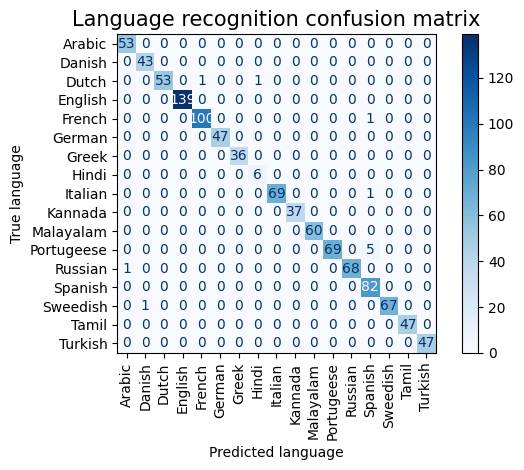

In [55]:
ConfusionMatrixDisplay.from_predictions(
    testing_labels, 
    predictions_test,
    display_labels=class_names,
    cmap="Blues",
)
plt.xticks(rotation=90)
plt.xlabel("Predicted language")
plt.ylabel("True language")
plt.title("Language recognition confusion matrix", fontsize=15)
plt.tight_layout()
plt.show()